<a href="https://colab.research.google.com/github/yasmws/English/blob/main/project2_yasmws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
pip install google-cloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
pip install google-colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516 kB 14.9 MB/s 
  Created wheel for tornado: filename=tornado-5.1.1-cp37-cp37m-linux_x86_64.whl size=463290 sha256=bc9b0d20bd89e441898183c08b0e2a515e8818e5cfec65588ef306f210333341
  Stored in directory: /root/.cache/pip/wheels/83/91/4b/ee8ffb993d3372fc4129c52c9140792c118dda0373b41e7a8f
Successfully built tornado
  Attempting uninstall: tornado
    Found existing installation: tornado 6.2
    Uninstalling tornado-6.2:
      Successfully uninstalled tornado-6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.19.1 requires tornado>=6.1.0, but you have tornado 5.1.1 which is incompatible.


In [54]:
pip install --upgrade google-api-python-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [56]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [57]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [58]:
key = os.environ.get('AZURE_SEARCH_KEY', '9253282967ac4620b6391f2717e32c98')

In [59]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [60]:
results = search_images_bing(key, 'pichu')
ims = results.attrgot('contentUrl')
len(ims)

150

In [61]:
#hide
ims = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/172.png']

In [62]:
dest = 'images/pichu.jpg'
download_url(ims[0], dest)

Path('images/pichu.jpg')

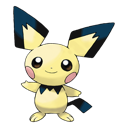

In [63]:
im = Image.open(dest)
im.to_thumb(128,128)

In [64]:
pokemon_types = 'pichu','pikachu','raichu'
path = Path('pokemon')

In [65]:
if not path.exists():
    path.mkdir()
    for o in pokemon_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} pokemon')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [66]:
fns = get_image_files(path)
fns

(#400) [Path('pokemon/pikachu/eed88b1c-6834-4faa-b63d-7976d2c65a68.jpg'),Path('pokemon/pikachu/a015e500-a344-4e4a-b9f0-702680cccbe7.jpeg'),Path('pokemon/pikachu/37e39021-e48b-4ce7-9559-e9e48e5b23e0.jpg'),Path('pokemon/pikachu/cb184fb2-d15c-4f93-a0e4-c03a5210be30.jpg'),Path('pokemon/pikachu/0755b85e-6cef-4688-b35f-e7f893444723.jpg'),Path('pokemon/pikachu/1a17003c-c907-48d1-832f-4255bcc850a3.png'),Path('pokemon/pikachu/e321c2fb-d79f-4f29-ab59-59bb7c4aa53d.jpg'),Path('pokemon/pikachu/342b607c-ff59-4921-8592-9ad35762d107.jpg'),Path('pokemon/pikachu/a7e781f6-ea9a-4a91-8bc3-896a37b77024.jpg'),Path('pokemon/pikachu/45bc0061-5564-45a6-898e-6873b7afb58b.jpg')...]

In [67]:
failed = verify_images(fns)
failed

(#0) []

In [68]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [69]:
pokemon = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [70]:
dls = pokemon.dataloaders(path)

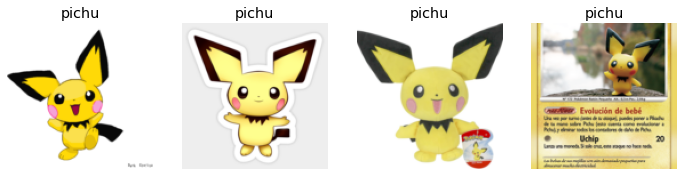

In [71]:
dls.valid.show_batch(max_n=4, nrows=1)

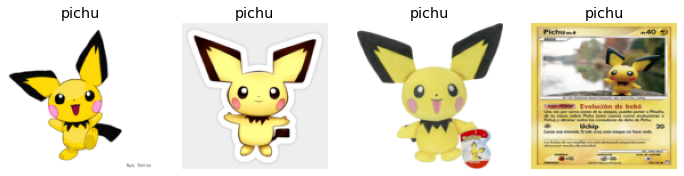

In [72]:
pokemon = pokemon.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pokemon.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

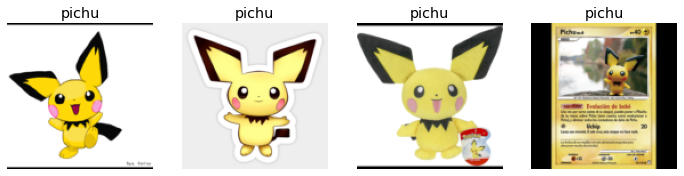

In [73]:
pokemon = pokemon.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pokemon.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

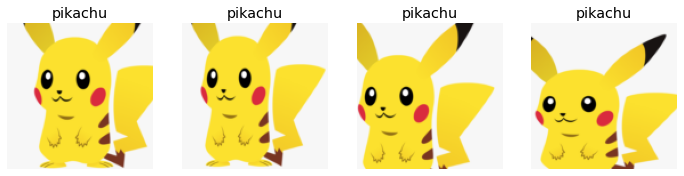

In [74]:
pokemon = pokemon.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pokemon.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

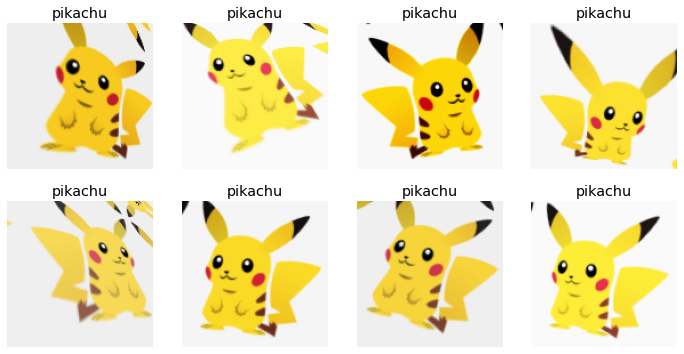

In [75]:
pokemon = pokemon.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pokemon.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [76]:
pokemon = pokemon.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pokemon.dataloaders(path)

In [77]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.678179,0.951185,0.300000,00:17


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.620176,0.575639,0.200000,00:09
1,0.556268,0.375160,0.125000,00:10
2,0.478015,0.327630,0.075000,00:09
3,0.422958,0.284975,0.062500,00:09


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

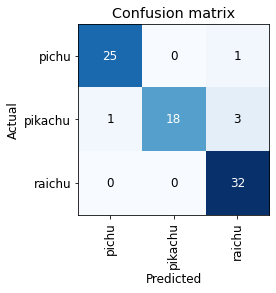

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

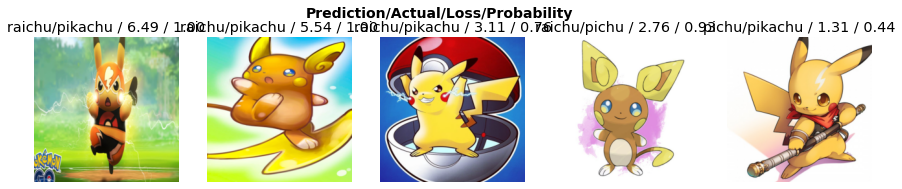

In [79]:
interp.plot_top_losses(5, nrows=1)

In [80]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [81]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [82]:
learn.export()

In [83]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('my_export.pkl')]

In [84]:
learn_inf = load_learner(path/'export.pkl')

In [85]:
learn_inf.predict('images/pichu.jpg')

('pichu', TensorBase(0), TensorBase([1.0000e+00, 1.1678e-07, 4.6060e-06]))

In [86]:
learn_inf.dls.vocab

['pichu', 'pikachu', 'raichu']

### Creating a Notebook App from the Model

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [89]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/pikachu.jpg'])

In [90]:
img = PILImage.create(btn_upload.data[-1])

In [91]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [92]:
pred,pred_idx,probs = learn_inf.predict(img)

In [93]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: pikachu; Probability: 0.9867')

In [94]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [95]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [96]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [97]:
VBox([widgets.Label('Select your pokemon!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [98]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
! pip install voila

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tornado-6.2-cp37-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (423 kB)
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0, but you have tornado 6.2 which is incompatible.


In [100]:
! jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila  OK


In [101]:
! pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
%load_ext watermark

%watermark -v -m -p wget,voila,fastbook,numpy,pandas,geopy,altair,vega_datasets,watermark

print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

wget         : 3.2
voila        : 0.3.6
fastbook     : 0.0.28
numpy        : 1.21.6
pandas       : 1.3.5
geopy        : 1.17.0
altair       : 4.2.0
vega_datasets: 0.9.0
watermark    : 2.3.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

 
Last updated: Mon Oct 10 2022 03:52:47UTC



In [103]:
learn.export(os.path.abspath('./export.pkl'))